In [3]:
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


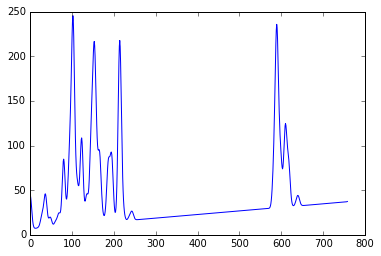

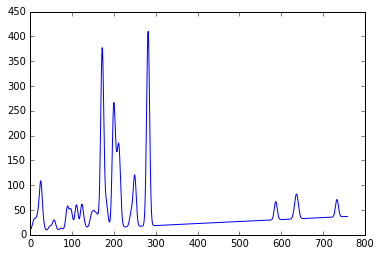

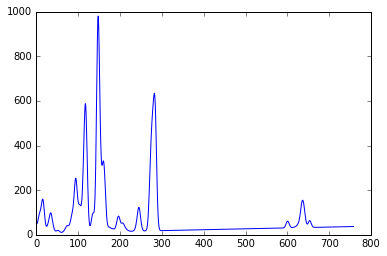

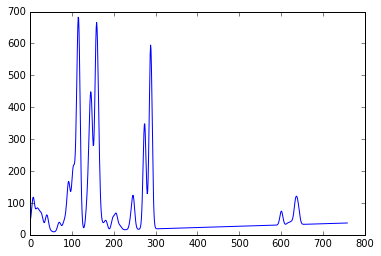

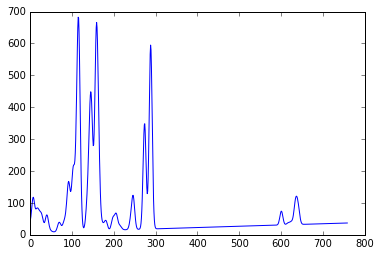

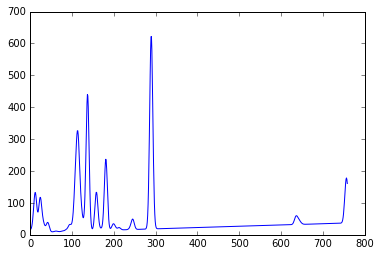

In [4]:
count = 5
with open("../../../target/thirs.txt") as f:
    for i in f:
        if count < 0:
            break
        plt.plot([float(y) for y in i.split()])
        plt.show()
        count -= 1